In [1]:
# https://en.wikipedia.org/wiki/Monty_Hall_problem

In [2]:
import gymnasium as gym
import random
from typing import Tuple, Dict, List
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MontyHallEnv(gym.Env):
    def __init__(self):
        self.observation_space = gym.spaces.MultiBinary(3) # the doors (False - closed, True - opened)
        self.action_space = gym.spaces.Discrete(3) # door to open - 0-based
        self._doors = None
        self._secret = None
    
    def reset(self, seed=1):
        super().reset(seed=seed) # this should take care also of seeding the random
        self._doors = [False] * 3
        self._secret = random.choice(range(3))
        return self._get_state()

    def _get_state(self) -> Tuple[List[bool], Dict]:
        info = {}
        return self._doors, info
    
    def step(self, door: int):
        assert 0 <= door < 3, f'{door}'
        done = False
        reward = 0.0
        if sum(self._doors) == 0:
            reveal_candidates = set(range(3)).difference([door, self._secret])
            reveal = random.choice(list(reveal_candidates))
            self._doors[reveal] = True
        else:
            assert sum(self._doors) == 1, f'{self._doors}'
            self._doors[door] = True
            reward = +1.0 if self._secret == door else 0.0
            done = True
        obs, info = self._get_state()
        truncated = False
        return obs, reward, done, truncated, info

In [4]:
env = MontyHallEnv()

In [5]:
env.reset()

([False, False, False], {})

In [6]:
env.step(0)

([False, False, True], 0.0, False, False, {})

In [7]:
env.step(1)

([False, True, True], 1.0, True, False, {})

In [8]:
def stick(trials: int) -> List[float]:
    ret = []
    for _ in range(trials):
        _ = env.reset()
        pick = random.choice(range(3))
        obs, *_ = env.step(pick)
        obs, reward, *_ = env.step(pick)
        ret.append(reward)
    return ret

In [9]:
rewards_when_stick = stick(1000)

In [10]:
def switch_(trials: int) -> List[float]:
    ret = []
    for _ in range(trials):
        _ = env.reset()
        pick = random.choice(range(3))
        obs, *_ = env.step(pick)
        assert sum(obs) == 1, f'{sum(obs)}'
        revealed = next(i for i in range(3) if obs[i])
        new_selection = set(range(3)).difference([pick, revealed])
        assert len(new_selection) == 1, f'{len(new_selection)}'
        obs, reward, *_ = env.step(list(new_selection)[0])
        ret.append(reward)
    return ret

In [11]:
rewards_when_switch = switch_(1000)

In [12]:
np.mean(rewards_when_stick)

np.float64(0.327)

In [13]:
np.mean(rewards_when_switch)

np.float64(0.674)

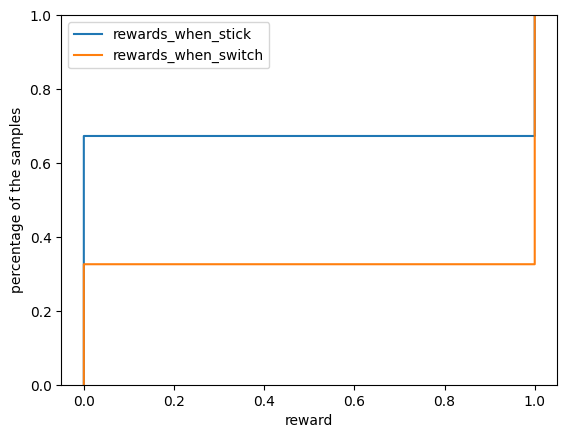

In [14]:
plt.ecdf(rewards_when_stick, label='rewards_when_stick')
plt.ecdf(rewards_when_switch, label='rewards_when_switch')
plt.xlabel('reward')
plt.ylabel('percentage of the samples')
plt.legend()
plt.show()